# Nonreciprocity in the system of two transmons

Computing nonreciprocity in the system of two superconducting qubits (transmons).

We compare two different approaches:
- Taking into account higher levels: we use the Hamiltonian expanded into Taylor series upto 4th power.
- Conventional approach with two qubits

In [1]:
import qutip as qt
import numpy as np
import qucat as qc
import scipy as sc
import matplotlib.pyplot as plt

import os

def clear_console():
    os.system('clear')

/Users/nikita/.python_envs/qutip/lib/python3.11/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
import h5py

def write_h5(file_name, data_dict):
    with h5py.File(file_name, "w") as f:
        for dset_name, dset_data in data_dict.items():
            f.create_dataset(dset_name, data=dset_data)
            print(dset_name, dset_data)
    return "File .h5 wrote successfully"

 ## System parameters

In [3]:
N_excitations = 3
N_qubits = 2
DIM = N_excitations**N_qubits
NMAX = 50
DIRECTION = 'L'
PATH_DATA = '/Users/jimi/Google Drive/Work/In process/Projects/Qubits_nonreciprocity/Data/'
PATH_FIGS = '/Users/jimi/Google Drive/Work/In process/Projects/Qubits_nonreciprocity/Figs/'

# Field parameters
a_mag = 0.1*np.sqrt(1.5e+9)
if DIRECTION == 'R':
    a_R = a_mag
    a_L = 0e-2
elif DIRECTION == 'L':
    a_R = 0e-2
    a_L = a_mag
a_inc = {'R': a_R, 'L': a_L}

L_js = [3.301e-9, 3.3e-9]

In [4]:
# intial state
psi0 = qt.basis(N_excitations, 0) # start without excitations
for j in range(N_qubits - 1):
    psi0 = qt.tensor(psi0, qt.basis(N_excitations, 0))
rho0 = qt.ket2dm(psi0)

# transition operators
a_ops = [qt.destroy(N_excitations) if i==0 else qt.qeye(N_excitations) for i in range(N_qubits)]

for i in range(N_qubits):
    for j in range(1, N_qubits):
        if i==j:
            j_op = qt.destroy(N_excitations)
        else: 
            j_op = qt.qeye(N_excitations)
            
        a_ops[i] = qt.tensor(a_ops[i], j_op)
        
# unity operator        
i_op = qt.qeye(N_excitations)
for j in range(1, N_qubits):
    i_op = qt.tensor(i_op, qt.qeye(N_excitations))

### Using qucat for transmons

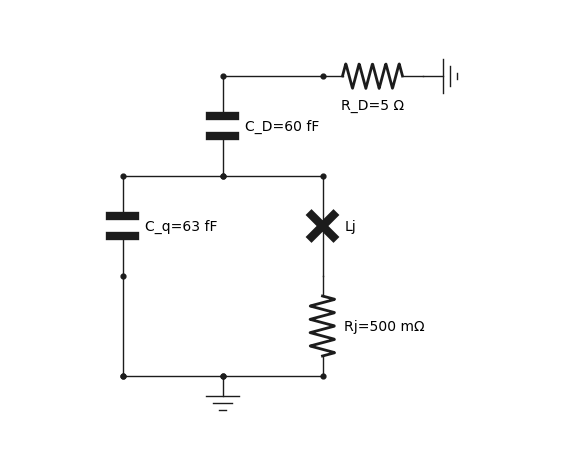

C 0 1 C_q=63 fF
J 1 3 Lj
R 0 3 Rj=500 mOhm
C 1 2 C_D=60 fF
R 0 2 R_D=5 Ohm




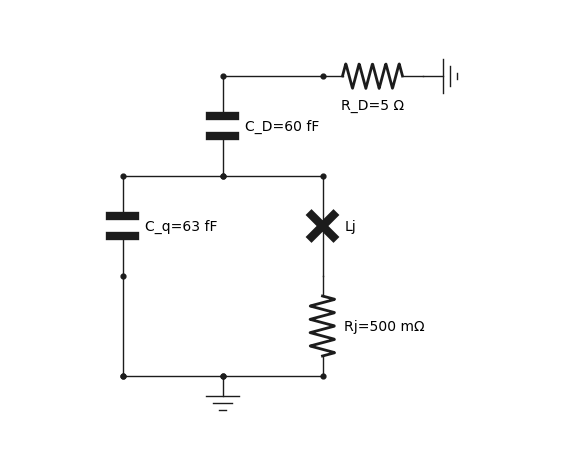

C 0 1 C_q=63 fF
J 1 3 Lj
R 0 3 Rj=500 mOhm
C 1 2 C_D=60 fF
R 0 2 R_D=5 Ohm




In [5]:
import qucat as qc
cir_1 = qc.GUI('circuits/1_transmon.txt', # location of the circuit file
        edit=False, # open the GUI to edit the circuit
        plot=True, # plot the circuit after having edited it
        print_network=True # print the network
       )
cir_2 = qc.GUI('circuits/1_transmon.txt', # location of the circuit file
        edit=False, # open the GUI to edit the circuit
        plot=True, # plot the circuit after having edited it
        print_network=True # print the network
       )
cirs = [cir_1, cir_2]

In [6]:
cir_1.f_k_A_chi(pretty_print=True, Lj=3.3e-9)

         mode |       freq.  |       diss.  |       anha.  |
            0 |      7.9 GHz |     81.5 MHz |      158 MHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |
            0 |      158 MHz |



(array([7.89981387e+09]),
 array([81496609.9500279]),
 array([1.57553819e+08]),
 array([[1.57553819e+08]]))

In [7]:
cir_2.f_k_A_chi(pretty_print=True, Lj=3.31e-9)

         mode |       freq.  |       diss.  |       anha.  |
            0 |     7.89 GHz |     81.3 MHz |      158 MHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |
            0 |      158 MHz |



(array([7.88787125e+09]),
 array([81250393.08240707]),
 array([1.575536e+08]),
 array([[1.575536e+08]]))

In [8]:
# Compute hamiltonian (for h=1, so all energies are expressed in frequency units, not angular)
H_t1 = 2.0*np.pi*cir_1.hamiltonian(
    #modes = [0,1],# Include modes 0 and 1
    taylor = 4,# Taylor the Josephson potential to the power 4
    excitations = N_excitations,
    Lj = 3.3e-9)# set any component values that were not fixed when building the circuit

H_t2 = 2.0*np.pi*cir_2.hamiltonian(
    #modes = [0,1],# Include modes 0 and 1
    taylor = 4,# Taylor the Josephson potential to the power 4
    excitations = N_excitations,
    Lj = 8e-9)# set any component values that were not fixed when building the circuit


# QuTiP method which return the eigenergies of the system
ee_1 = H_t1.eigenenergies()
ee_2 = H_t2.eigenenergies()

In [9]:
# transitions in GHz
np.array([ee_1[j+1] - ee_1[j] for j in range(N_excitations-1)])/(2*np.pi/1e-9)

array([7.82123384, 7.93939921])

In [10]:
# transitions in GHz
np.array([ee_2[j+1] - ee_2[j] for j in range(N_excitations-1)])/(2*np.pi/1e-9)

array([4.99525553, 5.11338904])

(None, <Axes: >)

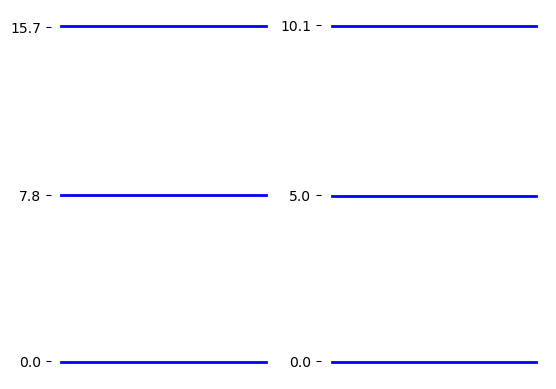

In [11]:
fig_energy, ax = plt.subplots(1, 2)
qt.plot_energy_levels([H_t1/(2*np.pi*1e9)], N=8, ax=ax[0], show_ylabels=True)
qt.plot_energy_levels([H_t2/(2*np.pi*1e9)], N=8, ax=ax[1], show_ylabels=True)

In [12]:
def cir_parameters_norm_modes(cir, L_j, t_j, a_inc):
    chi = 2.0*np.pi*cir.kerr(Lj = L_j)
    np.fill_diagonal(chi, 0)
    return {
    'w_m': 2.0*np.pi*cir.eigenfrequencies(Lj = L_j),
    'A_m': 2.0*np.pi*cir.anharmonicities(Lj = L_j),
    'gammas': 2.0*np.pi*cir.loss_rates(Lj = L_j),
    'chi_mn': chi,
    'Omega_R': np.array([1.0j*np.sqrt(2.0*np.pi*cir.anharmonicities(Lj = L_j)[j])*
                  (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                   a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                  for j in range(N_qubits)])}


def cir_parameters(cirs, L_js, a_inc):
    gammas = 2.0*np.pi*np.array([cirs[i].loss_rates(Lj = L_js[i])[0] for i in range(len(cirs))])
    w_m = 2.0*np.pi*np.array([cirs[i].eigenfrequencies(Lj = L_js[i])[0] for i in range(len(cirs))])
    w_ext = w_m[0]
    delta = (w_m[0] - w_m[1]) / np.mean(gammas)
    t_j = np.array([0.0, (np.pi - delta) / w_ext])
    t_ij = np.array([[t_j[i] - t_j[j] for j in range(len(cirs))] for i in range(len(cirs))])
    return {
    'a_inc': a_inc,
    'w_m': w_m,
    'w_ext': w_ext,
    'A_m': 2.0*np.pi*np.array([cirs[i].anharmonicities(Lj = L_js[i])[0] for i in range(len(cirs))]),
    'gammas': gammas,
    'gamma_nr': 0*190.0e3 * 2.0*np.pi,
    'gamma_phi': 0*200.0e3 * 2.0*np.pi,
    'delta': delta,
    't_j': t_j,
    't_ij': t_ij,
    'Omega_R': np.array([1.0j*np.sqrt(0.5*gammas[j])*
                  (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                   a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                  for j in range(len(cirs))]),
    'Omega': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   np.sin(w_ext * np.abs(t_ij[i,j]))
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    'Gamma': np.array([[np.sqrt(gammas[i]*gammas[j])*
                   np.cos(w_ext * np.abs(t_ij[i,j]))
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    'Omega_R_nonRWA': np.array([1.0j*np.sqrt(0.5*gammas[j])*np.sqrt(w_ext/w_m[j])*
                  (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                   a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                  for j in range(len(cirs))]),
    'Omega_nonRWA': np.array([[-1j*0.25*np.sqrt(gammas[i]*gammas[j])*
                   (
                       np.sqrt(w_m[i]/w_m[j])*np.exp(1j*w_m[i]*np.abs(t_ij[j,i])) - 
                       np.sqrt(w_m[j]/w_m[i])*np.exp(-1j*w_m[j]*np.abs(t_ij[i,j]))                              
                   )
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    'Gamma_nonRWA': np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   (
                       np.sqrt(w_m[i]/w_m[j])*np.exp(1j*w_m[i]*np.abs(t_ij[j,i])) + 
                       np.sqrt(w_m[j]/w_m[i])*np.exp(-1j*w_m[j]*np.abs(t_ij[i,j]))                              
                   )
                   for j in range(len(cirs))] 
                  for i in range(len(cirs))]),
    # output operators
    'out_ops': {'R': a_inc['R']*i_op + sum([np.exp(-1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))]),
                'L': a_inc['L']*i_op + sum([np.exp(1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))])},
    # for non-rotating frame, a_in * exp(-i w_ext t) as an input signal
    'out_ops_t': {'R': sum([np.exp(-1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))]),
                  'L': sum([np.exp(1j*w_m[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(len(cirs))])}
    }

In [13]:
a_inc

{'R': 0.0, 'L': 3872.9833462074166}

In [14]:
p = cir_parameters(cirs, L_js, a_inc)
out_ops = p['out_ops']

In [15]:
p["Gamma_nonRWA"]

array([[ 5.11903178e+08     +0.j        ,
        -5.11923695e+08+122980.18716352j],
       [-5.11923695e+08-122980.18716352j,
         5.12058302e+08     +0.j        ]])

In [16]:
p["Gamma"]

array([[ 5.11903178e+08, -5.11925521e+08],
       [-5.11925521e+08,  5.12058302e+08]])

In [17]:
p["gamma_phi"]/np.mean(p["gammas"])

0.0

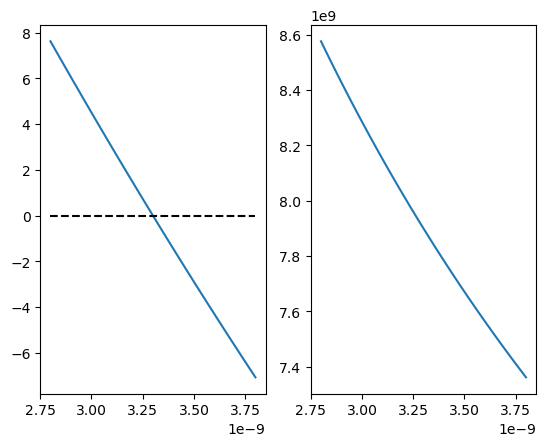

In [18]:
L_j_list = np.linspace(2.80e-9, 3.80e-9, NMAX)

fig_par, ax = plt.subplots(1, 2)
ax[0].plot(L_j_list, np.array([cir_parameters(cirs, [j, 3.3e-9], a_inc)['delta'] for j in L_j_list]), 
       label='delta')
ax[0].plot(L_j_list, np.array([0.0 for j in L_j_list]), '--', color='black')
ax[1].plot(L_j_list, np.array([cir_1.eigenfrequencies(Lj=j) for j in L_j_list]))

## Hamiltonian and Liouvillian

In [19]:
def hamiltonian_transmon(parameters):
    p = parameters
    
    H_0 = sum([(p['w_m'][j] - p['w_ext'])*a_ops[j].dag()*a_ops[j] 
               - 0.5*p['A_m'][j]*a_ops[j].dag()*a_ops[j].dag()*a_ops[j]*a_ops[j]#(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_f = sum([p['Omega_R'][j]*a_ops[j] + np.conj(p['Omega_R'][j])*a_ops[j].dag() for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    return H_0 + H_f + H_d, H_0, H_f, H_d


def hamiltonian_transmon_time_drive(args):
    p = args
    H_0 = sum([(p['w_m'][j] - p['w_ext'])*a_ops[j].dag()*a_ops[j] 
               - 0.5*p['A_m'][j]*a_ops[j].dag()*a_ops[j].dag()*a_ops[j]*a_ops[j]#(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega_nonRWA'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    time_dep_coeff_m = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}]))) * \
        exp(-1j*w_ext*t)'
        for j in range(N_qubits)
        ]
    time_dep_coeff_p = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}]))) * \
        exp(1j*w_ext*t)'
        for j in range(N_qubits)
        ]
    H = [H_0, H_d,
        *[ [a_ops[i], time_dep_coeff_m[i]] for i in range(N_qubits) ],
        *[ [a_ops[i].dag(), time_dep_coeff_p[i]] for i in range(N_qubits) ]
        ]
    arguments_dict = {
        f'g': p['gammas'],
        'w_ext': p['w_ext'],
        f'w': p['w_m'],
        'a_L': p['a_inc']['L'],
        f't_j': p['t_j'],
        'a_R': p['a_inc']['R']
    }
    return H, arguments_dict


def hamiltonian_transmon_time_drive_nonrotating(args):
    p = args
    H_0 = sum([(p['w_m'][j])*a_ops[j].dag()*a_ops[j] 
               - 0.5*p['A_m'][j]*a_ops[j].dag()*a_ops[j].dag()*a_ops[j]*a_ops[j]
               #- 1.0/12.0*p['A_m'][j]*(a_ops[j].dag() + a_ops[j])**4
               for j in range(N_qubits)])
    H_d = sum(sum([[p['Omega'][i,j]*a_ops[i].dag()*a_ops[j]#(a_ops[i] - a_ops[i].dag())*(a_ops[j] - a_ops[j].dag())
                    for j in range(N_qubits)] for i in range(N_qubits)], []))
    time_dep_coeff = [
        f'-2.0*sqrt(0.5*g[{j}])*sqrt(w_ext/w[{j}]) * \
        (a_L*sin(w_ext*(t+t_j[{j}])) + a_R*sin(w_ext*(t-t_j[{j}])))'
        for j in range(N_qubits)
        ]
    H = [H_0, H_d,
        *[ [(a_ops[i] + a_ops[i].dag()), time_dep_coeff[i]] for i in range(N_qubits) ]
        ]
    arguments_dict = {
        f'g': p['gammas'],
        'w_ext': p['w_ext'],
        f'w': p['w_m'],
        'a_L': a_inc['L'],
        f't_j': p['t_j'],
        'a_R': a_inc['R']
    }
    return H, arguments_dict


def jump_operators(a_ops, args):
    J_ops = []
    Gamma = args["Gamma_nonRWA"]
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [ np.sqrt(lam[i])*sum([b[j, i] * a_ops[j] for j in range(N_qubits) ]) for i in range(N_qubits)]
    return J_ops


def dark_bright_states(a_ops, args):
    J_ops = []
    Gamma = args["Gamma"]
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [ sum([b[j, i] * a_ops[j] for j in range(N_qubits) ]) for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    # ground state
    psi0 = qt.basis(N_excitations, 0) # start without excitations
    for j in range(N_qubits - 1):
        psi0 = qt.tensor(psi0, qt.basis(N_excitations, 0))
    return qt.ket2dm(J_D.dag()*psi0), qt.ket2dm(J_B.dag()*psi0)


def dark_bright_states_nonRWA(a_ops, args):
    J_ops = []
    Gamma = args["Gamma_nonRWA"]
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [ sum([b[j, i] * a_ops[j] for j in range(N_qubits) ]) for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    # ground state
    psi0 = qt.basis(N_excitations, 0) # start without excitations
    for j in range(N_qubits - 1):
        psi0 = qt.tensor(psi0, qt.basis(N_excitations, 0))
    return qt.ket2dm(J_D.dag()*psi0), qt.ket2dm(J_B.dag()*psi0)


def DB_basis(a_ops, args, RWA=True):
    gg = qt.basis(N_excitations, 0) # ground state
    ee = qt.basis(N_excitations, 1) # excited state
    for j in range(N_qubits - 1):
        gg = qt.tensor(gg, qt.basis(N_excitations, 0))
        ee = qt.tensor(ee, qt.basis(N_excitations, 1))
    if RWA:
        Gamma = args["Gamma"]
    else:
        Gamma = args["Gamma_nonRWA"]
    J_ops = []
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [ sum([b[j, i] * a_ops[j] for j in range(N_qubits) ]) for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    dd = J_D.dag() * gg
    bb = J_B.dag() * gg
    basis = np.eye(N_excitations**2, dtype=complex)
    basis[:, 1] = ((dd.data).toarray()).flatten()
    basis[:, N_excitations] = ((bb.data).toarray()).flatten()
    return basis, gg, dd, bb, ee


def DB_basis_full(a_ops, args, RWA=True):
    N_exc = a_ops[0].dims[0][0]
    gg = qt.basis(N_exc, 0)  # ground state
    ee = qt.basis(N_exc, 1)  # excited state
    for j in range(N_qubits - 1):
        gg = qt.tensor(gg, qt.basis(N_exc, 0))
        ee = qt.tensor(ee, qt.basis(N_exc, 1))
    if RWA:
        Gamma = args["Gamma"]
    else:
        Gamma = args["Gamma_nonRWA"]
    J_ops = []
    lam, b = sc.linalg.eig(Gamma)
    J_ops = [sum([b[j, i] * a_ops[j] for j in range(N_qubits)])
             for i in range(N_qubits)]
    # dark and bright operators
    for j in range(len(lam)):
        if lam[j] == np.min(lam):
            J_D = J_ops[j]
        elif lam[j] == np.max(lam):
            J_B = J_ops[j]
    dd = J_D.dag() * gg
    bb = J_B.dag() * gg
    dd2 = (dd.dag()*qt.basis([N_exc,N_exc], [1, 0])*qt.basis([N_exc,N_exc], [2, 0]) + 
           dd.dag()*qt.basis([N_exc,N_exc], [0, 1])*qt.basis([N_exc,N_exc], [0, 2])) # J_D.dag() * J_D.dag() * gg
    bb2 = (bb.dag()*qt.basis([N_exc,N_exc], [1, 0])*qt.basis([N_exc,N_exc], [2, 0]) + 
           bb.dag()*qt.basis([N_exc,N_exc], [0, 1])*qt.basis([N_exc,N_exc], [0, 2])) # J_B.dag() * J_B.dag() * gg
    basis = np.eye(N_exc**2, dtype=complex)
    basis[:, 1] = ((dd.data).toarray()).flatten()
    basis[:, N_exc] = ((bb.data).toarray()).flatten()
    if N_exc > 2:
        basis[:, 2] = ((dd2.data).toarray()).flatten()
        basis[:, 2*N_exc] = ((bb2.data).toarray()).flatten()
    return basis, gg, dd, bb, ee, dd2, bb2

In [20]:
def transmission(direction: str, rho, a_inc):
    return qt.expect(out_ops[direction].dag()*out_ops[direction], 
                     rho) / np.abs(a_inc)**2


def transmission_f(direction: str, rho, a_inc):
    return np.abs(qt.expect(out_ops[direction], rho) / a_inc)

In [21]:
H, H_0, H_f, H_i = hamiltonian_transmon(p)
L_diss = sum([sum([p['Gamma'][i,j]*qt.lindblad_dissipator(a_ops[i], a_ops[j]) 
                   for j in range(N_qubits)]) for i in range(N_qubits)])
c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) for j in range(len(a_ops))]
L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
L = L_0 + L_diss

In [22]:
H_t, H_args = hamiltonian_transmon_time_drive(p)

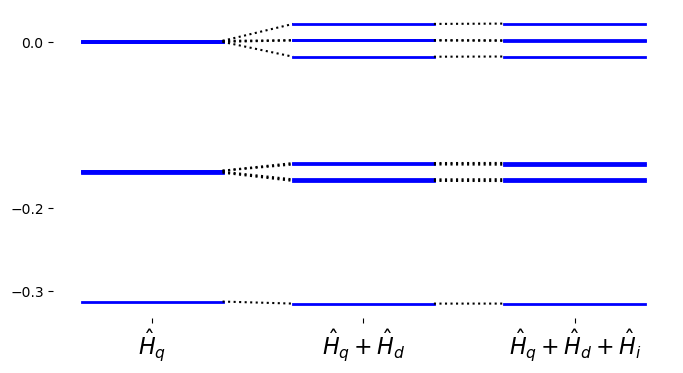

In [23]:
fig_levels = qt.plot_energy_levels([H_0/(2*np.pi*1e9), H_f/(2*np.pi*1e9), H_i/(2*np.pi*1e9)], N=9, figsize=(8, 4), 
                                   labels=[r'$\hat{H}_q$', r'$\hat{H}_q+\hat{H}_d$', r'$\hat{H}_q+\hat{H}_d+\hat{H}_i$'], show_ylabels=True)
#fig_levels[0].savefig(PATH_FIGS + "levels_Nexc" + str(N_excitations) + ".pdf", dpi=300)

In [24]:
L

Quantum object: dims = [[[3, 3], [3, 3]], [[3, 3], [3, 3]]], shape = (81, 81), type = super, isherm = False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j -6.19645785e+07-9.10097053e+05j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 6.19645785e+07-9.10097053e+05j -2.56029151e+08-7.51911291e+06j
  -8.76311473e+07-1.28707160e+06j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  8.76311473e+07-1.28707160e+06j
  -5.12058302e+08+9.74901613e+08j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ... -1.53586466e+09-9.74901613e+08j
  -6.19645785e+07-9.10097053e+05j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+0

In [25]:
sc.linalg.eigvals(p["Gamma"])

array([5.52130550e+04+0.j, 1.02390627e+09+0.j])

(-1100000000.0, 50000000.0)

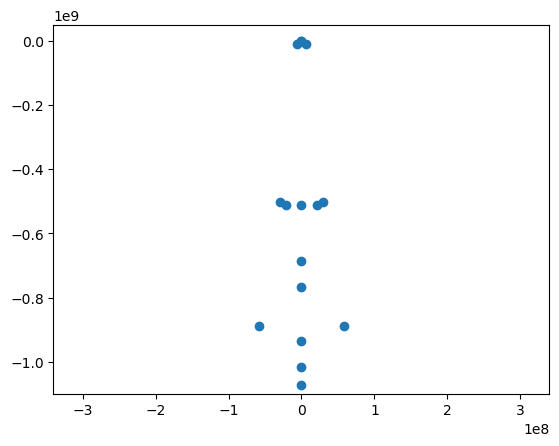

In [26]:
fig_eigL, ax = plt.subplots(1,1)
ax.plot(np.imag(L.eigenenergies()), np.real(L.eigenenergies()), 'o')
ax.set_xlim(-3.4e8, 3.4e8)
ax.set_ylim(-1.1e9, 0.05e9)

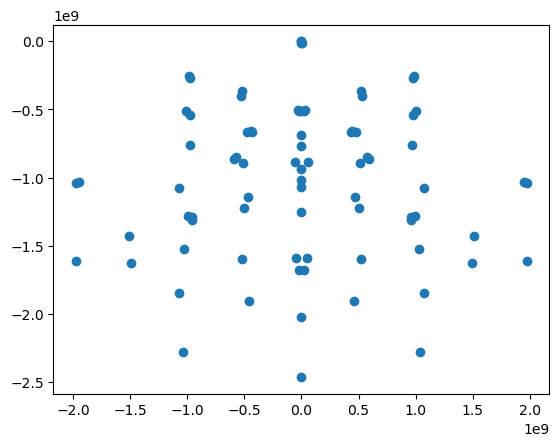

In [27]:
plt.plot(np.imag(L.eigenenergies()), np.real(L.eigenenergies()), 'o')

## Hamiltonian and Gamma study

In [28]:
# Hamiltonian eigenenergies

def hamiltonian_eigenenergies(a_in, L_j1, L_j2, direction: str = 'R', cutoff=None):
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = cir_parameters(cirs, L_js, a_inc)
    out_ops = p['out_ops']
    H, _, _, _ = hamiltonian_transmon(p)
    return H.eigenenergies() if cutoff == None else H.eigenenergies()[cutoff[0]:cutoff[1]]


# Gamma eigenvalues

def gamma_eigvals(a_in, L_j1, L_j2, direction: str = 'R'):
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = cir_parameters(cirs, L_js, a_inc)
    Gamma = p["Gamma"]
    return sc.linalg.eigvals(Gamma)

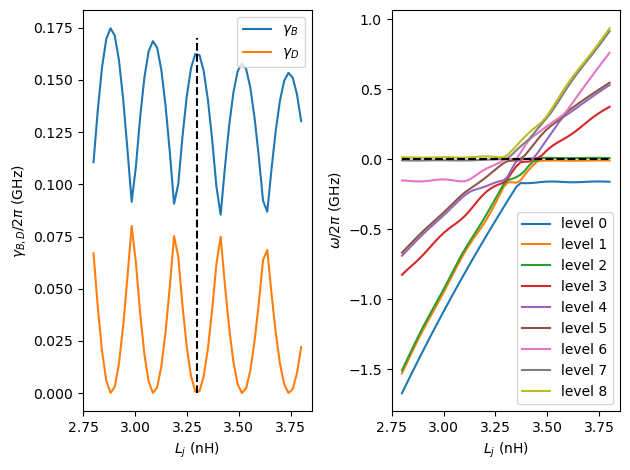

In [29]:
cutoff = [0, 25]
L_js_for_H = L_js#[3.31e-9, 3.3e-9]
H_eigs = np.array([hamiltonian_eigenenergies(a_mag, j, L_js_for_H[1], cutoff=cutoff) for j in L_j_list])
gammas_B = np.array([np.max(gamma_eigvals(a_mag, j, L_js_for_H[1])) for j in L_j_list])
gammas_D = np.array([np.min(gamma_eigvals(a_mag, j, L_js_for_H[1])) for j in L_j_list])

fig_eg, ax = plt.subplots(1, 2)
ax[0].plot(L_j_list/1e-9, np.real(gammas_B)/(2*np.pi*1e9), label=r'$\gamma_B$')
ax[0].plot(L_j_list/1e-9, np.real(gammas_D)/(2*np.pi*1e9), label=r'$\gamma_D$')
ax[0].plot([L_js_for_H[1]/1e-9, L_js_for_H[1]/1e-9], np.linspace(0.0, 0.17, 2), '--', color='black')
ax[0].set_xlabel(r"$L_j$ (nH)")
ax[0].set_ylabel(r"$\gamma_{B,D} / 2\pi$ (GHz)")
ax[0].legend()

ax[1].plot(L_j_list/1e-9, np.real(H_eigs)/(2*np.pi*1e9), ms=2, label=[f'level {j+cutoff[0]}' for j in range(len(H_eigs[0]))])
ax[1].plot(L_j_list/1e-9, [0.0 for j in L_j_list], '--', color='black')
ax[1].plot(L_js_for_H[1]/1e-9, 0.0, color='r')
ax[1].set_xlabel(r"$L_j$ (nH)")
ax[1].set_ylabel(r"$\omega / 2\pi$ (GHz)")
# ax[1].set_ylim(-0.01, 0.01)
ax[1].legend()

fig_eg.tight_layout()

## Time evolution

In [30]:
# ODE solver options
opts = qt.Options(atol=1e-16, rtol=1e-14, method='adams', order=12, nsteps=10000, first_step=0, max_step=0, 
        min_step=0, average_expect=True, average_states=False, tidy=True, num_cpus=0, norm_tol=0.001, 
        norm_t_tol=1e-06, norm_steps=5, rhs_reuse=False, rhs_filename=None, ntraj=500, gui=False, 
        rhs_with_state=False, store_final_state=False, store_states=False, steady_state_average=False, 
        seeds=None, normalize_output=True, use_openmp=None, openmp_threads=None)


In [31]:
w = np.real(sc.linalg.eigvals(p['Gamma']))

In [ ]:
tlist = np.linspace(0.0, 1e1/np.min(w), 2000)
rho_ss = qt.steadystate(L, method='direct', maxiter=1e9, tol=1e-24, use_precond=True)
result_t = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[], options=qt.Options(nsteps=1e7))
J_ops = jump_operators(a_ops, p)
result_tt = qt.mesolve(H_t, rho0, tlist, c_ops=J_ops + c_ops_nr + c_ops_deph, e_ops=[], args=H_args, progress_bar=True, 
                       options=qt.Options(nsteps=1e7, rhs_reuse=False))

In [342]:
basis_DB, gg, dd, bb, ee = DB_basis(a_ops, p)
basis_DB_full, _, _, _, _, dd2, bb2 = DB_basis_full(a_ops, p)

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 3.40631144e-01+0.00000000e+00j  1.51949904e-02-2.77621866e-02j
   9.91204499e-04+1.45455994e-03j -5.80528872e-02-1.15536018e-03j
  -9.80053843e-03-3.78859859e-04j -5.48492226e-04+3.33187956e-04j
  -9.58973748e-04-1.53798523e-03j  3.26326664e-04-2.71347727e-04j
  -4.70557200e-06-4.16861172e-05j]
 [ 1.51949904e-02+2.77621866e-02j  6.45101984e-01+0.00000000e+00j
  -1.75682832e-02+3.20264058e-02j -2.33379329e-03-1.22091652e-04j
  -1.40303856e-03-5.39473905e-04j -1.66364257e-03-1.48755673e-03j
   1.61145846e-02-3.15624105e-02j -1.52010928e-03-1.47716936e-03j
   2.59798391e-06-6.01553333e-06j]
 [ 9.91204499e-04-1.45455994e-03j -1.75682832e-02-3.20264058e-02j
   2.07242085e-03+0.00000000e+00j  5.44398255e-05+1.10788822e-04j
   1.15503350e-05+8.48282096e-05j -2.87187517e-05+1.23658574e-04j
  -2.00780654e-03+5.99409818e-05j -3.21410221e-05+1.16159994e-04j
  -3.72820527e-07+3.63301921e-08j]
 [-5.80

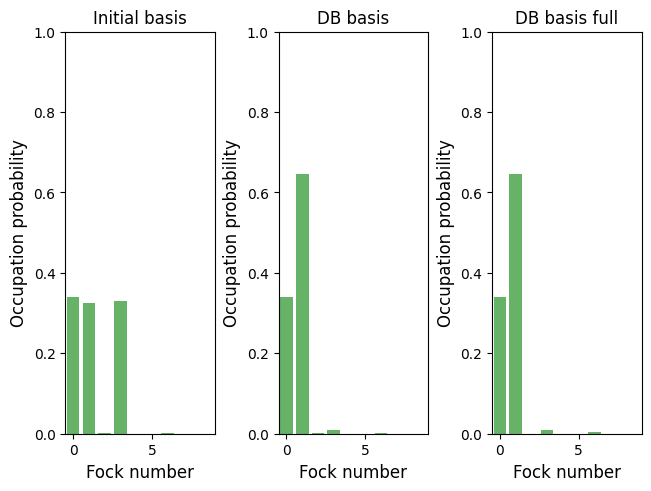

In [343]:
basis_DB, gg, dd, bb, ee = DB_basis(a_ops, p)
rho_D, rho_B = dark_bright_states(a_ops, p)
rho_ss = qt.steadystate(L, method='direct', maxiter=1e9, tol=1e-24, use_precond=True)

fig_rho_ss, ax = plt.subplots(1, 3, constrained_layout=True)
qt.plot_fock_distribution(rho_ss, fig=fig_rho_ss, ax=ax[0], title="Initial basis")
qt.plot_fock_distribution(rho_ss.transform(basis_DB), fig=fig_rho_ss, ax=ax[1], title="DB basis")
qt.plot_fock_distribution(rho_ss.transform(basis_DB_full), fig=fig_rho_ss, ax=ax[2], title="DB basis full")
rho_ss.transform(basis_DB)

In [257]:
(rho_D*rho_ss).tr()

0.6451019842856656

In [348]:
transmission_f(DIRECTION, rho_ss, a_inc[DIRECTION])

0.5744398636248303

In [259]:
print(transmission_f(DIRECTION, rho_ss, a_inc[DIRECTION]), 
      transmission_f(DIRECTION, result_t.states[-1], a_inc[DIRECTION]),
      transmission_f(DIRECTION, result_tt.states[-1], a_inc[DIRECTION]))

0.5744398636248303 0.5744398641666657 0.5763405433284483


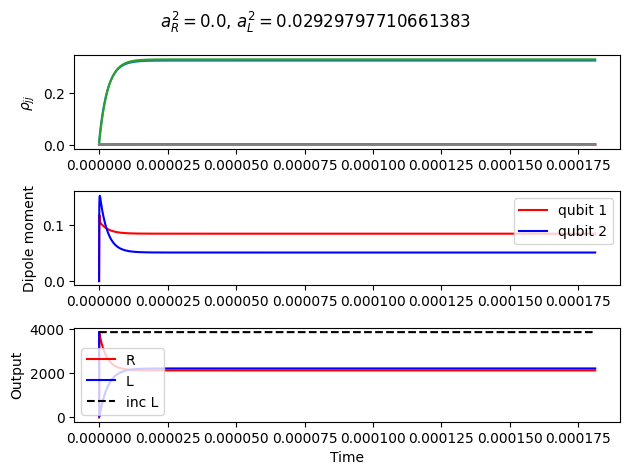

In [260]:
fig_0, ax = plt.subplots(3, 1)
ax[0].plot(tlist, [result_t.states[i].diag()[1:DIM] for i in range(len(tlist))])
ax[0].set_ylabel(r'$\rho_{jj}$')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[0], result_t.states)), color='r', label='qubit 1')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[1], result_t.states)), color='b', label='qubit 2')
ax[1].set_ylabel('Dipole moment')
ax[1].legend()
ax[2].plot(tlist, np.abs(qt.expect(out_ops['R'], result_t.states)), color='r', label='R')
ax[2].plot(tlist, np.abs(qt.expect(out_ops['L'], result_t.states)), color='b', label='L')
ax[2].plot(tlist, [np.abs(a_inc[DIRECTION]) for i in tlist], '--', color='black', 
           label='inc '+ DIRECTION)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Output')
ax[2].legend()
fig_0.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_0.tight_layout()

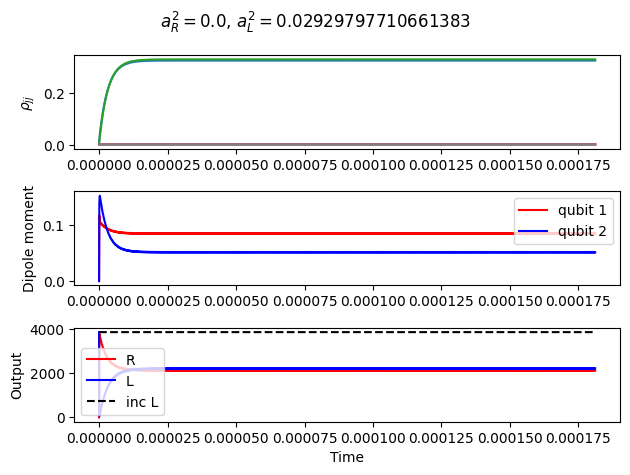

In [261]:
fig_0, ax = plt.subplots(3, 1)
ax[0].plot(tlist, [result_tt.states[i].diag()[1:DIM] for i in range(len(tlist))])
ax[0].set_ylabel(r'$\rho_{jj}$')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[0], result_tt.states)), color='r', label='qubit 1')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[1], result_tt.states)), color='b', label='qubit 2')
ax[1].set_ylabel('Dipole moment')
ax[1].legend()
# ax[2].plot(tlist, np.abs(qt.expect(p['out_ops_t']['R'], result_tt.states) + a_inc['R']*np.exp(-1j*p['w_ext']*tlist)) , color='r', label='R')
# ax[2].plot(tlist, np.abs(qt.expect(p['out_ops_t']['L'], result_tt.states) + a_inc['L']*np.exp(-1j*p['w_ext']*tlist)), color='b', label='L')
ax[2].plot(tlist, np.abs(qt.expect(out_ops['R'], result_tt.states)), color='r', label='R')
ax[2].plot(tlist, np.abs(qt.expect(out_ops['L'], result_tt.states)), color='b', label='L')
ax[2].plot(tlist, [np.abs(a_inc[DIRECTION]) for i in tlist], '--', color='black', 
           label='inc '+ DIRECTION)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Output')
ax[2].legend()
fig_0.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_0.tight_layout()

In [221]:
rho_ss

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 4.24119849e-01+0.00000000e+00j -4.56392983e-02+1.65504316e-01j
   6.51478149e-03+1.65407655e-02j -1.22772557e-01+1.59069171e-01j
  -1.21127331e-02-7.40470650e-04j -1.77008337e-03+2.93867462e-04j
  -8.01533365e-03-1.07609032e-02j -3.55649124e-04-8.09673250e-05j
   1.39587503e-05-6.05090824e-05j]
 [-4.56392983e-02-1.65504316e-01j  2.69953449e-01+0.00000000e+00j
   1.73974169e-02-1.98879431e-02j  2.76258132e-01+2.00275445e-03j
   5.83542939e-03+3.74342679e-03j  1.20580137e-03+1.39562382e-03j
  -8.31624877e-03+1.77576113e-02j  5.75109510e-04+9.92086491e-04j
  -2.78791645e-05+2.18255454e-05j]
 [ 6.51478149e-03-1.65407655e-02j  1.73974169e-02+1.98879431e-02j
   2.64340088e-03+0.00000000e+00j  1.82748333e-02+2.12030333e-02j
   1.56873214e-04+7.85223393e-04j -2.00002717e-05+1.88104723e-04j
  -1.88018518e-03+5.47717222e-04j -4.14862769e-05+1.06713104e-04j
  -3.98368299e-06-4.63478223e-07j]
 [-1.22

In [222]:
rho_ss.transform(basis_DB)

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 4.24119849e-01+0.00000000e+00j  1.19126836e-01-2.29504567e-01j
   6.51478149e-03+1.65407655e-02j -5.44503748e-02-4.72582973e-03j
  -1.21127331e-02-7.40470650e-04j -1.77008337e-03+2.93867462e-04j
  -8.01533365e-03-1.07609032e-02j -3.55649124e-04-8.09673250e-05j
   1.39587503e-05-6.05090824e-05j]
 [ 1.19126836e-01+2.29504567e-01j  5.61913052e-01+0.00000000e+00j
  -2.52245570e-02+2.90564106e-02j -1.52553111e-02-2.00275445e-03j
  -1.00026113e-02-5.74091079e-03j -1.86187326e-03-2.01170915e-03j
   1.20007989e-02-2.59479659e-02j -7.75551416e-04-1.47363942e-03j
   4.27261394e-05-3.88197440e-05j]
 [ 6.51478149e-03-1.65407655e-02j -2.52245570e-02-2.90564106e-02j
   2.64340088e-03+0.00000000e+00j  6.01139000e-04+9.07691211e-04j
   1.56873214e-04+7.85223393e-04j -2.00002717e-05+1.88104723e-04j
  -1.88018518e-03+5.47717222e-04j -4.14862769e-05+1.06713104e-04j
  -3.98368299e-06-4.63478223e-07j]
 [-5.44

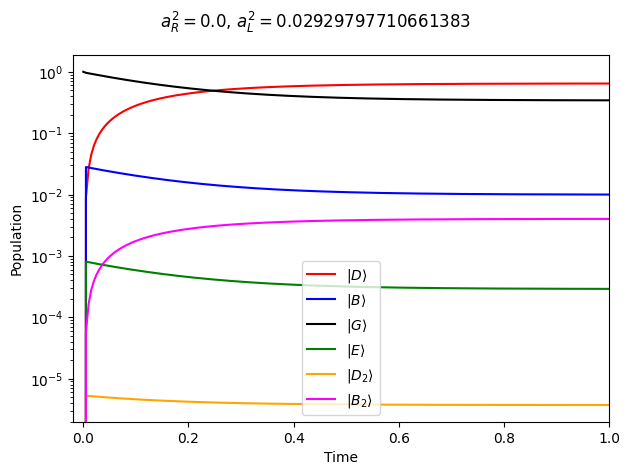

In [409]:
fig_states, ax = plt.subplots(1, 1)
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(dd), result_t.states)), color='r', label=r'$|D\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(bb), result_t.states)), color='b', label=r'$|B\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(gg), result_t.states)), color='black', label=r'$|G\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(ee), result_t.states)), color='green', label=r'$|E\rangle$')
# ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(qt.basis([3,3],[0,2])), result_t.states)), color='orange', label=r'$|0,2\rangle$')
# ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(qt.basis([3,3],[2,0])), result_t.states)), color='magenta', label=r'$|2,0\rangle$')
# ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(1/np.sqrt(2)*(qt.basis([3,3],[2,0])+qt.basis([3,3],[0,2]))), result_t.states)), color='orange', label=r'$|B_2\rangle$')
# ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(1/np.sqrt(2)*(qt.basis([3,3],[2,0])-qt.basis([3,3],[0,2]))), result_t.states)), color='magenta', label=r'$|D_2\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(dd2), result_t.states)), color='orange', label=r'$|D_2\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(bb2), result_t.states)), color='magenta', label=r'$|B_2\rangle$')
ax.set_ylabel('Population')
ax.set_yscale("log")
ax.legend()
ax.set_xlabel('Time')
ax.set_xlim(-0.02, 1)
fig_states.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_states.tight_layout()

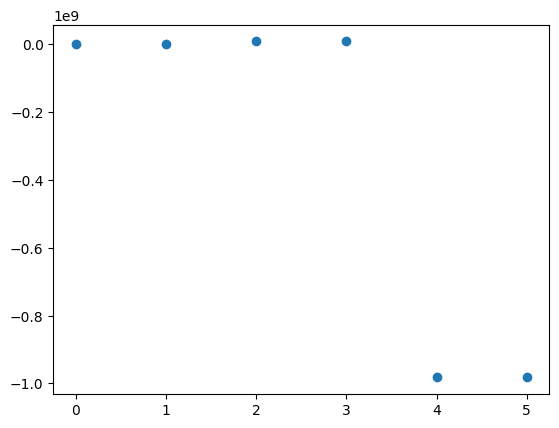

In [322]:
def state_energy(H, state):
    return state.dag() * H * state

list_of_states = [gg, dd, bb, ee, 
                  1/np.sqrt(2)*(qt.basis([3,3],[0,2])+qt.basis([3,3],[2,0])),
                  1/np.sqrt(2)*(qt.basis([3,3],[0,2])-qt.basis([3,3],[2,0]))]

fig_st, ax = plt.subplots(1,1)
ax.plot(np.real(np.array([state_energy(H, ket)[0,0] for ket in list_of_states])), 'o')

In [463]:
import pandas as pd

list_states = [gg, dd, bb, ee, bb2, dd2]
tabl = np.array([[np.abs(((ket2.dag() * H * ket1) * (ket2.dag() * H * ket1).dag())[0,0]) 
                  for ket2 in list_states] for ket1 in list_states])

states = ['gg', 'dd', 'bb', 'ee', 'bb2', 'dd2']
tabl_clean = (tabl - np.diag(np.diag(tabl)))/np.max(tabl-np.diag(np.diag(tabl)))
transition_df = pd.DataFrame(tabl_clean, columns=states, index=states)

In [464]:
transition_df

,gg,dd,bb,ee,bb2,dd2
gg,0.000000,0.000054,1.000000,0.000000e+00,0.000000e+00,0.000000
dd,0.000054,0.000000,0.001840,5.394689e-05,1.000000e+00,0.000054
bb,1.000000,0.001840,0.000000,1.000000e+00,5.397558e-05,1.000000
ee,0.000000,0.000054,1.000000,0.000000e+00,4.224811e-11,0.007362
bb2,0.000000,1.000000,0.000054,4.224811e-11,0.000000e+00,0.007362
dd2,0.000000,0.000054,1.000000,7.361741e-03,7.362135e-03,0.000000


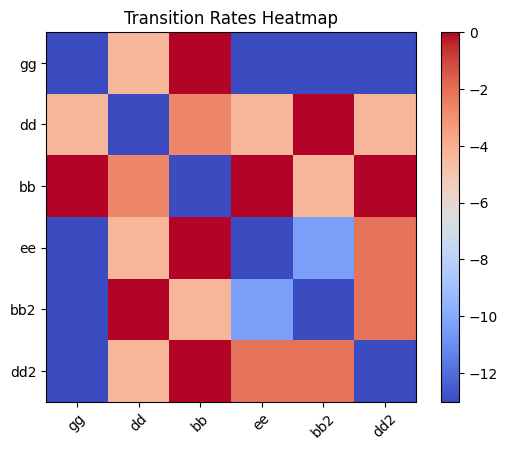

In [465]:
# Create a basic heatmap using Matplotlib
log_transition_df = np.log10(transition_df+1e-13)

plt.imshow(log_transition_df, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(states)), states, rotation=45)
plt.yticks(range(len(states)), states)
plt.title('Transition Rates Heatmap')

plt.show()

In [466]:
qt.operator_to_vector(qt.ket2dm(dd)).dag()*L*qt.operator_to_vector(qt.ket2dm(dd2))

tabl_L = np.array([[np.abs((qt.operator_to_vector(qt.ket2dm(ket2)).dag()*L*qt.operator_to_vector(qt.ket2dm(ket1)))[0,0]) 
                  for ket2 in list_states] for ket1 in list_states])
transition_df_L = pd.DataFrame(tabl_L, columns=states, index=states)

In [467]:
transition_df_L

,gg,dd,bb,ee,bb2,dd2
gg,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
dd,5.521305e+04,5.521305e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bb,1.023906e+09,2.526576e-09,1.023906e+09,0.000000e+00,0.000000e+00,0.000000e+00
ee,0.000000e+00,5.523656e+04,1.023906e+09,1.023961e+09,0.000000e+00,0.000000e+00
bb2,0.000000e+00,1.023906e+09,5.526594e+04,0.000000e+00,1.023962e+09,0.000000e+00
dd2,0.000000e+00,5.521893e+04,1.023906e+09,0.000000e+00,5.960464e-08,1.023961e+09


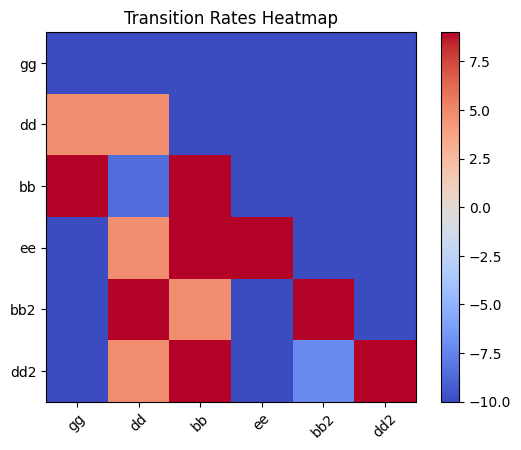

In [482]:
log_transition_df_L = np.log10(transition_df_L+1e-10)

plt.imshow(log_transition_df_L, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(states)), states, rotation=45)
plt.yticks(range(len(states)), states)
plt.title('Transition Rates Heatmap')

plt.show()

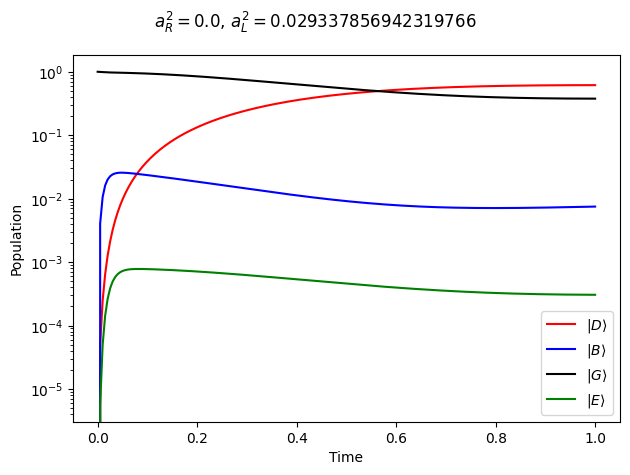

In [148]:
fig_states, ax = plt.subplots(1, 1)
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(dd), result_t.states)), color='r', label=r'$|D\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(bb), result_t.states)), color='b', label=r'$|B\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(gg), result_t.states)), color='black', label=r'$|G\rangle$')
ax.plot(tlist*np.min(w), np.abs(qt.expect(qt.ket2dm(ee), result_t.states)), color='green', label=r'$|E\rangle$')
ax.set_ylabel('Population')
ax.set_yscale("log")
ax.legend()
ax.set_xlabel('Time')
fig_states.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_states.tight_layout()

In [212]:
(L_js, a_inc)

([3.301e-09, 3.3e-09], {'R': 0.0, 'L': 3872.9833462074166})

In [486]:
dict_states_evo = {'tlist': tlist, 'rho_ss': (rho_ss.data).toarray(), 'direction': DIRECTION, 'a_inc': a_mag, 
                'N_excitations': N_excitations, 'delta': p["delta"],
                'gamma_D': np.min(w), 'gamma_B': np.max(w),
                'gg': np.abs(qt.expect(qt.ket2dm(gg), result_t.states)),
                'dd': np.abs(qt.expect(qt.ket2dm(dd), result_t.states)),
                'bb': np.abs(qt.expect(qt.ket2dm(bb), result_t.states)),
                'ee': np.abs(qt.expect(qt.ket2dm(ee), result_t.states)),
                'bb2': np.abs(qt.expect(qt.ket2dm(bb2), result_t.states)),
                'dd2': np.abs(qt.expect(qt.ket2dm(dd2), result_t.states)),
                'tran_rates_H': tabl, 'tran_rates_L': tabl_L,
                'L_js': L_js}

In [487]:
write_h5(PATH_DATA+"states_evo_Nexc"+ str(N_excitations) + "_" + DIRECTION+"_ainc_"+
         str(np.round(a_inc[DIRECTION]**2/np.mean(p['gammas']), decimals=2))+"_delta_" + 
         str(np.round(p['delta'], decimals=3)) + ".h5", dict_states_evo)

tlist [0.00000000e+00 9.06035946e-08 1.81207189e-07 ... 1.80935378e-04
 1.81025982e-04 1.81116586e-04]
rho_ss [[ 3.40631144e-01+0.00000000e+00j  3.03090330e-02+2.04463681e-02j
   9.91204499e-04+1.45455994e-03j -5.17917750e-02+1.88154164e-02j
  -9.80053843e-03-3.78859859e-04j -5.48492226e-04+3.33187956e-04j
  -9.58973748e-04-1.53798523e-03j  3.26326664e-04-2.71347727e-04j
  -4.70557200e-06-4.16861172e-05j]
 [ 3.03090330e-02-2.04463681e-02j  3.25138288e-01+0.00000000e+00j
   1.23832134e-02-2.25660276e-02j  3.17581429e-01+1.22091652e-04j
  -1.92375672e-04+3.54431924e-04j  1.11857578e-03+1.08512918e-03j
  -1.13540785e-02+2.22203195e-02j  1.12129360e-03+1.00303694e-03j
  -2.48622187e-06-7.65407157e-07j]
 [ 9.91204499e-04-1.45455994e-03j  1.23832134e-02+2.25660276e-02j
   2.07242085e-03+0.00000000e+00j  1.24620851e-02+2.27261378e-02j
   1.15503350e-05+8.48282096e-05j -2.87187517e-05+1.23658574e-04j
  -2.00780654e-03+5.99409818e-05j -3.21410221e-05+1.16159994e-04j
  -3.72820527e-07+3.63301921

'File .h5 wrote successfully'

## Coherence functions and spectra: time independent

In [38]:
taulist = np.linspace(0.0, 1e1/np.min(w), 10000)
g1_tau_R, _ = qt.coherence_function_g1(L, None, taulist, c_ops=[], a_op=out_ops['R'], options=qt.Options(nsteps=1e7))
g1_tau_L, _ = qt.coherence_function_g1(L, None, taulist, c_ops=[], a_op=out_ops['L'], options=qt.Options(nsteps=1e7))
g2_tau_R, _ = qt.coherence_function_g2(L, None, taulist, c_ops=[], a_op=out_ops['R'], options=qt.Options(nsteps=1e7))
g2_tau_L, _ = qt.coherence_function_g2(L, None, taulist, c_ops=[], a_op=out_ops['L'], options=qt.Options(nsteps=1e7))

In [39]:
_, spec_R = qt.spectrum_correlation_fft(taulist, g1_tau_R-g1_tau_R[-1])
w_spec, spec_L = qt.spectrum_correlation_fft(taulist, g1_tau_L-g1_tau_L[-1])

/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


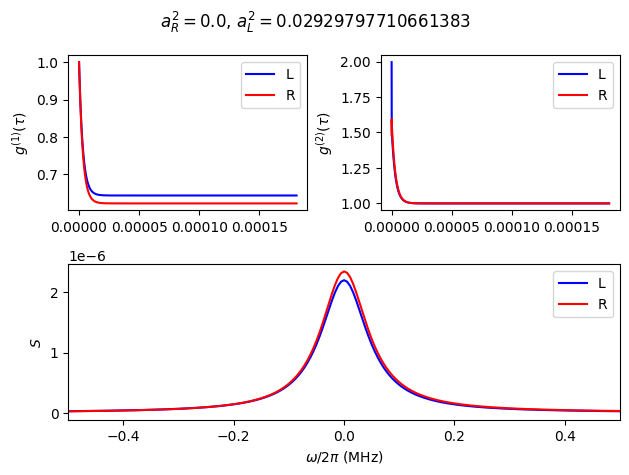

In [40]:
fig_coh, ax = plt.subplots(2, 2)
gs = ax[1, 0].get_gridspec()
# remove the underlying axes
for ax_i in ax[1, :]:
    ax_i.remove()
axbig = fig_coh.add_subplot(gs[1, :])
    
ax[0,0].plot(taulist, g1_tau_L, color='b', label='L')
ax[0,0].plot(taulist, g1_tau_R, color='r', label='R')
ax[0,0].set_ylabel(r'$g^{(1)}(\tau)$')
ax[0,0].legend()
ax[0,1].plot(taulist, g2_tau_L, color='b', label='L')
ax[0,1].plot(taulist, g2_tau_R, color='r', label='R')
ax[0,1].set_ylabel(r'$g^{(2)}(\tau)$')
#ax[1].set_yscale('log')
ax[0,1].legend()
axbig.plot(w_spec/(2*np.pi*1e6), spec_L, color='b', label='L')
axbig.plot(w_spec/(2*np.pi*1e6), spec_R, color='r', label='R')
axbig.set_xlim(-5e-1,5e-1)
axbig.set_ylabel(r'$S$')
axbig.set_xlabel(r'$\omega / 2\pi$ (MHz)')
axbig.legend()
fig_coh.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_coh.tight_layout()

### Writing time dependent variables to file

In [268]:
data_dict =  {'g_D(L_j)': np.real(gammas_D), 'g_B(L_j)': np.real(gammas_B), 'H_eig(L_j)': H_eigs, 'L_j_list': L_j_list}
dict_time_dep = {'tlist': tlist, 'rho_ss': (rho_ss.data).toarray(), 'direction': DIRECTION, 'a_inc': a_mag, 
                'N_excitations': N_excitations, 'delta': p["delta"],
                'dipole_1': np.abs(qt.expect(a_ops[0], result_tt.states)),
                'dipole_2': qt.expect(a_ops[1], result_tt.states),
                'output_R': qt.expect(p['out_ops_t']['R'], result_tt.states) + a_inc['R']*np.exp(-1j*p['w_ext']*tlist),
                'output_L': qt.expect(p['out_ops_t']['L'], result_tt.states) + a_inc['L']*np.exp(-1j*p['w_ext']*tlist),
                'g1_R': g1_tau_R, 'g1_L': g1_tau_L, 'g2_R': g2_tau_R, 'g2_L': g2_tau_L, 'taulist': taulist,
                'w_spec': w_spec, 'spec_R': spec_R, 'spec_L': spec_L,
                'L_js': L_js}
data_dict.update(dict_time_dep)

In [269]:
write_h5(PATH_DATA+"time_dependence_Nexc"+ str(N_excitations) + "_" + DIRECTION+"_ainc_"+
         str(np.round(a_inc[DIRECTION]**2/np.mean(p['gammas']), decimals=2))+"_delta_" + 
         str(np.round(p['delta'], decimals=3)) + ".h5", data_dict)

g_D(L_j) [4.20761467e+08 4.04501927e+08 3.88217050e+08 3.71973850e+08
 3.55822813e+08 3.39803897e+08 3.23950090e+08 3.08289586e+08
 2.92847167e+08 2.77645101e+08 2.62703741e+08 2.48041934e+08
 2.33677304e+08 2.19626453e+08 2.05905100e+08 1.92528187e+08
 1.79509947e+08 1.66863964e+08 1.54603209e+08 1.42740066e+08
 1.31286358e+08 1.20253356e+08 1.09651791e+08 9.94918631e+07
 8.97832405e+07 8.05350669e+07 7.17559598e+07 6.34540116e+07
 5.56367886e+07 4.83113301e+07 4.14841469e+07 3.51612203e+07
 2.93480000e+07 2.40494031e+07 1.92698129e+07 1.50130777e+07
 1.12825098e+07 8.08088581e+06 5.41044558e+06 3.27289306e+06
 1.66939669e+06 6.00590399e+05 6.65750336e+04 6.69201844e+04
 6.00666430e+05 1.66632801e+06 3.26189594e+06 5.38484151e+06
 8.03212030e+06 1.12001765e+07 1.48849477e+07 1.90818701e+07
 2.37858842e+07 2.89914405e+07 3.46925062e+07 4.08825717e+07
 4.75546574e+07 5.47013215e+07 6.23146671e+07 7.03863504e+07
 7.89075884e+07 8.78691675e+07 9.72614511e+07 1.07074389e+08
 1.17297523e+08

'File .h5 wrote successfully'

## Time dependent coherence functions and spectra

In [417]:
def g12_time_dep(H, rho0, taus, c_ops, a_op, args={}, func='g1'):
    # first calculate the occupation number as a function of time
    n = qt.mesolve(H, rho0, taus, c_ops, e_ops=[a_op.dag()*a_op], args=args, 
                       options=qt.Options(nsteps=1e7, rhs_reuse=False)).expect[0]

    # calculate the correlation function G1(2) and normalize with n(0)n(t) to
    # obtain g1(2)
    if func == 'g1':
        G1 = qt.correlation_2op_1t(H, rho0, taus, c_ops, 
                                   a_op.dag(), a_op,
                                   solver='me', 
                                   reverse=False, args=args, 
                                   options=qt.Options(nsteps=1e7))
        return  n, G1 / np.sqrt((n[0] * n))
    elif func == 'g2':
        G2 = qt.correlation_3op_1t(H, rho0, taus, c_ops, 
                                   a_op.dag(), a_op.dag()*a_op, a_op,
                                   solver='me', 
                                   args=args, 
                                   options=qt.Options(nsteps=1e7))
        return n, G2 / (n[0] * n)

In [418]:
def g1_time_dep(H, rho0, tlist, taus, c_ops, params, direction='R', args={}):
    p = params
    t = tlist[-1]
    a_op = p['out_ops_t'][direction]
    a_op0 = a_inc[direction]*np.exp(-1j*p['w_ext']*t) + a_op
    
    # first calculate the occupation number as a function of time
    result_norm = qt.mesolve(H, rho0, taus, c_ops, e_ops=[], args=args, 
                             options=qt.Options(nsteps=1e7, rhs_reuse=False))
    n = (qt.expect(a_op.dag()*a_op, result_norm.states) + 
         np.conj(a_inc[direction])*np.exp(1j*p['w_ext']*(t + taus)) * qt.expect(a_op, result_norm.states) +
         a_inc[direction]*np.exp(-1j*p['w_ext']*(t + taus)) * qt.expect(a_op.dag(), result_norm.states) +
         np.abs(a_inc[direction])**2
        )

    # calculate the correlation function G1(2) and normalize with n(0)n(t) to
    # obtain g1(2)
    rho_ic = a_op0 * rho0
    result_G1 =  qt.mesolve(H, rho_ic, taus, c_ops, e_ops=[], args=args, 
                            options=qt.Options(nsteps=1e7, rhs_reuse=False))
    G1 = np.array([ 
        qt.expect(np.conj(a_inc[direction])*np.exp(1j*p['w_ext']*(t + taus[j])) + 
                  a_op.dag(), result_G1.states[j]) 
        for j in range(len(taus))])
    
    return n, qt.expect(a_op0.dag()*a_op0, rho0), G1/np.sqrt(n[0]*n)

In [104]:
test, test0, g1_test = g1_time_dep(H_t, result_tt.states[-1], tlist, taulist, 
                                   J_ops + c_ops_nr + c_ops_deph,
                                   p, direction=DIRECTION, args=H_args)

In [244]:
test, g1_test = g12_time_dep(H_t, result_tt.states[-1], taulist, J_ops + c_ops_nr + c_ops_deph, out_ops['L'],
                             args=H_args, func='g1')

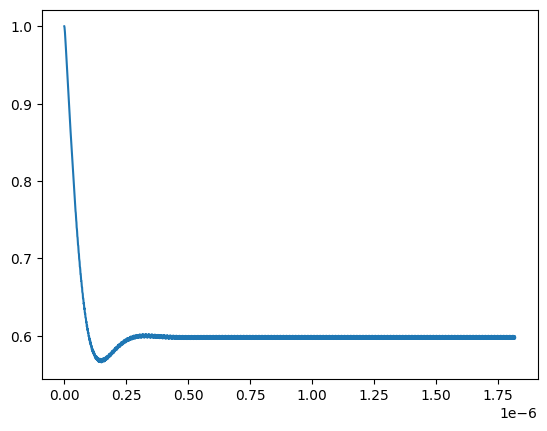

In [256]:
plt.plot(taulist, np.abs(g1_test))

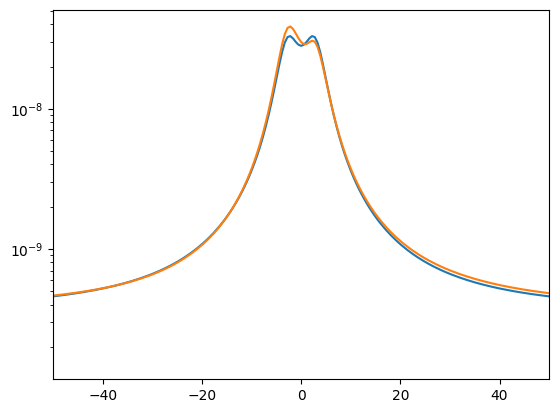

In [259]:
w_test, spec_test = qt.spectrum_correlation_fft(taulist, np.abs(g1_test)-np.abs(np.mean(g1_test[-(len(taulist)//10):-1])))
fig_test, ax = plt.subplots(1,1)
ax.plot(w_test/(2*np.pi*1e6), spec_test)
ax.plot(w_spec/(2*np.pi*1e6), spec_L)
ax.set_xlim(-50, 50)
ax.set_yscale('log')

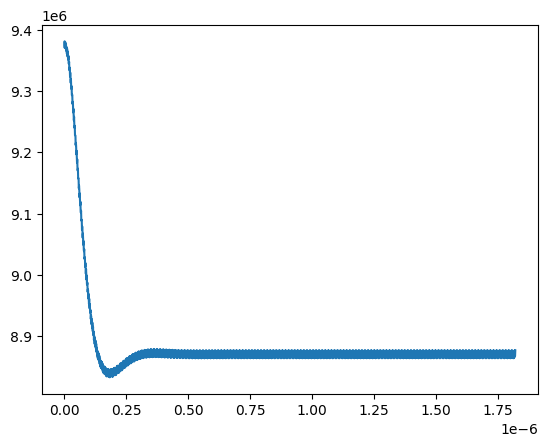

In [261]:
plt.plot(taulist, test)

In [419]:
taulist = np.linspace(0.0, 1e1/np.min(w), 2000)
_, g1_tau_R_t = g12_time_dep(H_t, result_tt.states[-1], taulist, J_ops + c_ops_nr + c_ops_deph, 
                          a_op=out_ops['R'], args=H_args)
_, g1_tau_L_t = g12_time_dep(H_t, result_tt.states[-1], taulist, J_ops + c_ops_nr + c_ops_deph, 
                          a_op=out_ops['L'], args=H_args)
_, g2_tau_R_t = g12_time_dep(H_t, result_tt.states[-1], taulist, J_ops + c_ops_nr + c_ops_deph, 
                          a_op=out_ops['R'], args=H_args, func='g2')
_, g2_tau_L_t = g12_time_dep(H_t, result_tt.states[-1], taulist, J_ops + c_ops_nr + c_ops_deph, 
                          a_op=out_ops['L'], args=H_args, func='g2')

In [420]:
_, spec_R_t = qt.spectrum_correlation_fft(taulist, np.abs(g1_tau_R_t)-np.abs(np.mean(g1_tau_R_t[-(len(taulist)//10):-1])))
w_spec_t, spec_L_t = qt.spectrum_correlation_fft(taulist, np.abs(g1_tau_L_t)-np.abs(np.mean(g1_tau_L_t[-(len(taulist)//10):-1])))

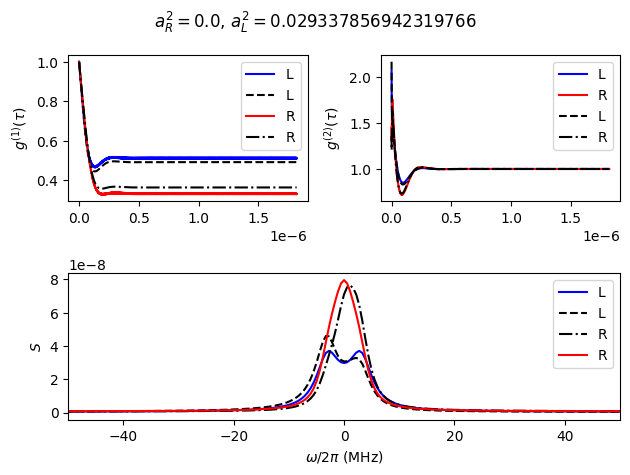

In [421]:
fig_coh_t, ax = plt.subplots(2, 2)
gs = ax[1, 0].get_gridspec()
# remove the underlying axes
for ax_i in ax[1, :]:
    ax_i.remove()
axbig = fig_coh_t.add_subplot(gs[1, :])
    
ax[0,0].plot(taulist, np.abs(g1_tau_L_t), color='b', label='L')
ax[0,0].plot(taulist, np.abs(g1_tau_L), '--',color='black', label='L')
ax[0,0].plot(taulist, np.abs(g1_tau_R_t), color='r', label='R')
ax[0,0].plot(taulist, np.abs(g1_tau_R), '-.', color='black', label='R')
ax[0,0].set_ylabel(r'$g^{(1)}(\tau)$')
ax[0,0].legend()
ax[0,1].plot(taulist, np.abs(g2_tau_L_t), color='b', label='L')
ax[0,1].plot(taulist, np.abs(g2_tau_R_t), color='r', label='R')
ax[0,1].plot(taulist, np.abs(g2_tau_L), '--', color='black', label='L')
ax[0,1].plot(taulist, np.abs(g2_tau_R), '-.', color='black', label='R')
ax[0,1].set_ylabel(r'$g^{(2)}(\tau)$')
#ax[1].set_yscale('log')
ax[0,1].legend()
axbig.plot(w_spec_t/(2*np.pi*1e6), spec_L_t, color='b', label='L')
axbig.plot(w_spec/(2*np.pi*1e6), spec_L, '--', color='black', label='L')
axbig.plot(w_spec/(2*np.pi*1e6), spec_R, '-.', color='black', label='R')
axbig.plot(w_spec_t/(2*np.pi*1e6), spec_R_t, color='r', label='R')
axbig.set_xlim(-5e1,5e1)
#axbig.set_ylim(0,1e-8)
axbig.set_ylabel(r'$S$')
axbig.set_xlabel(r'$\omega / 2\pi$ (MHz)')
axbig.legend()
fig_coh_t.suptitle(r"$a_R^2 = %s$, $a_L^2 = %s$" % (a_inc['R']**2/np.mean(p['gammas']), 
                                            a_inc['L']**2/np.mean(p['gammas'])))
fig_coh_t.tight_layout()

## Incident power dependence

In [501]:
def transmission_power_dependence(a_in, L_j1, L_j2, direction: str = 'R'):
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = cir_parameters(cirs, L_js, a_inc)
    out_ops = p['out_ops']
    rho_D, rho_B = dark_bright_states(a_ops, p)
    
    H, _, _, _ = hamiltonian_transmon(p)
    L_diss = sum([sum([p['Gamma'][i,j]*qt.lindblad_dissipator(a_ops[i], a_ops[j]) 
                       for j in range(N_qubits)]) for i in range(N_qubits)])
    c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
    c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) 
                  for j in range(len(a_ops))]
    L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
    L = L_0 + L_diss
    
    rho_ss = qt.steadystate(L, method='direct', maxiter=1e9, tol=1e-24, use_precond=True)
    return (qt.expect(out_ops[direction].dag()*out_ops[direction], 
                  rho_ss) / np.abs(a_inc[direction])**2), (rho_ss * rho_D).tr(), (rho_ss * rho_B).tr()#, (rho_ss.data).toarray()  # intensity transmission
    # return np.abs(qt.expect(out_ops[direction], rho_ss) / a_inc[direction])**2, (rho_ss * rho_D).tr(), (rho_ss * rho_B).tr()
    
    
def transmission_power_dependence_time_dependent(a_in, L_j1, L_j2, direction: str = 'R'):
    if direction == 'R':
        a_inc = {'R': a_in, 'L': 0.0}
    elif direction == 'L':
        a_inc = {'R': 0.0, 'L': a_in}
    L_js = [L_j1, L_j2]
    p = cir_parameters(cirs, L_js, a_inc)
    out_ops = p['out_ops']
    rho_D, rho_B = dark_bright_states_nonRWA(a_ops, p)
    
    H_t, H_args = hamiltonian_transmon_time_drive(p)
    J_ops = jump_operators(a_ops, p)
    c_ops_nr = [np.sqrt(p["gamma_nr"]) * a_ops[j] for j in range(len(a_ops))]
    c_ops_deph = [np.sqrt(p["gamma_phi"]) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) 
                  for j in range(len(a_ops))]
    # Master equation
    w = np.real(sc.linalg.eigvals(p['Gamma_nonRWA']))
    tlist = np.linspace(0.0, 1e1/np.min(w), 2)
    result_tt = qt.mesolve(H_t, rho0, tlist, c_ops=J_ops + c_ops_nr + c_ops_deph, e_ops=[], args=H_args, 
                       options=qt.Options(nsteps=1e7, rhs_reuse=False))
    rho_ss = result_tt.states[-1]
    
    return (qt.expect(out_ops[direction].dag()*out_ops[direction], 
                  rho_ss) / np.abs(a_inc[direction])**2), np.real((rho_ss * rho_D).tr()), np.real((rho_ss * rho_B).tr())  # intensity transmission
    # return np.abs(qt.expect(out_ops[direction], rho_ss) / a_inc[direction])**2, (rho_ss * rho_D).tr(), (rho_ss * rho_B).tr()
    

In [511]:
transmission_power_dependence(0.1*a_mag, 3.3e-9, 3.3e-9, direction='L')

(0.00015499395718550062, 0.00019628457977895273, 0.00029279208391117103)

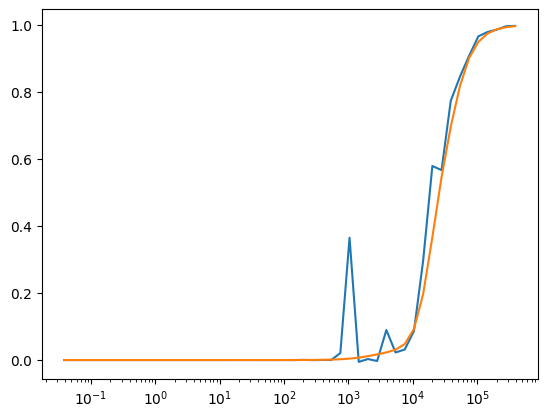

In [516]:
fig00, ax = plt.subplots(1,1)
ax.plot(a_inc_list, [transmission_power_dependence(i, 3.3e-9, 3.3e-9, direction='L')[0] for i in a_inc_list])
ax.plot(a_inc_list, [transmission_power_dependence(i, 3.31e-9, 3.3e-9, direction='R')[0] for i in a_inc_list])
ax.set_xscale("log")

In [ ]:
transmission_power_dependence_time_dependent(1*a_mag, 3.31e-9, 3.3e-9, direction='L')

Traceback (most recent call last):
  File "qutip/cy/cqobjevo.pyx", line 212, in qutip.cy.cqobjevo.CQobjEvo.mul_vec
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "qutip/cy/cqobjevo.pyx", line 679, in qutip.cy.cqobjevo.CQobjEvoTd._mul_vec
  File "qutip/cy/cqobjevo.pyx", line 293, in qutip.cy.cqobjevo.CQobjEvo._factor_dyn
  File "qutip/cy/cqobjevo.pyx", line 278, in qutip.cy.cqobjevo.CQobjEvo._factor
  File "/Users/jimi/Google Drive/Work/In process/Projects/Qubits_nonreciprocity/Notebooks/qobjevo_compiled_coeff_7506502546160.py", line 73, in __call__
    def __call__(self, t, args={}):
KeyboardInterrupt

Extension modules: zmq.backend.cython.context

In [68]:
test = qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),
                                          task_kwargs=dict(direction='R'),
                                          progress_bar=True)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.32s. Est. time left: 00:00:00:00
50.0%. Run time:   0.37s. Est. time left: 00:00:00:00
60.0%. Run time:   0.38s. Est. time left: 00:00:00:00
70.0%. Run time:   0.45s. Est. time left: 00:00:00:00
80.0%. Run time:   0.46s. Est. time left: 00:00:00:00
90.0%. Run time:   0.51s. Est. time left: 00:00:00:00
100.0%. Run time:   0.55s. Est. time left: 00:00:00:00
Total run time:   0.57s


In [65]:
test[0]

(-5.988047688316502e-11,
 2.9293954023643174e-12,
 2.92939515473456e-12,
 array([[ 1.00000000e+00+0.00000000e+00j,  2.60653149e-12+1.31857954e-12j,
         -4.36513408e-13+8.46305666e-13j, -2.42051085e-06+1.31477265e-12j,
         -2.92769370e-12+9.23381970e-16j, -1.68421998e-18+5.86376777e-19j,
          4.38982389e-13-8.44999797e-13j,  8.26371939e-19-1.35505721e-18j,
         -2.25025141e-25-1.22776432e-24j],
        [ 2.60653149e-12-1.31857954e-12j, -8.22112937e-17+0.00000000e+00j,
         -2.27371017e-23+6.05634770e-23j, -8.85219567e-17+3.31238549e-18j,
          3.20446768e-24+2.72085098e-23j, -1.97381155e-29-1.29741691e-29j,
          2.65513412e-23-5.14362854e-23j, -3.72487311e-29-3.34926431e-29j,
         -1.06238995e-35+2.36281749e-36j],
        [-4.36513408e-13-8.46305666e-13j, -2.27371017e-23-6.05634770e-23j,
          9.06724772e-25+0.00000000e+00j,  1.05657690e-18+2.04845111e-18j,
          1.27873999e-24+2.47733427e-24j,  1.23146213e-30+1.16937738e-30j,
         -9.0673

In [509]:
a_inc_list = 10.0**np.linspace(-6, 1, NMAX)*np.sqrt(1.5e+9)  # field amplitudes
L_j1_list = 3.3001e-09
L_j2_list = 3.3e-9

result_R = np.array(qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),
                                          task_kwargs=dict(direction='R'),
                                          progress_bar=True))
result_L = np.array(qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),  
                                          task_kwargs=dict(direction='L'),
                                          progress_bar=True))

transmission_R = result_R[:, 0]
pop_D_R = result_R[:, 1]
pop_B_R = result_R[:, 2]
transmission_L = result_L[:, 0]
pop_D_L = result_L[:, 1]
pop_B_L = result_L[:, 2]
efficiency = (np.maximum(transmission_L, transmission_R)*np.abs((transmission_L - transmission_R) /
                         (transmission_L + transmission_R)))
cir_parameters(cirs, [L_j1_list, L_j2_list], a_inc)['delta']

10.0%. Run time:   0.21s. Est. time left: 00:00:00:01
20.0%. Run time:   0.28s. Est. time left: 00:00:00:01
30.0%. Run time:   0.29s. Est. time left: 00:00:00:00
40.0%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.36s. Est. time left: 00:00:00:00
60.0%. Run time:   0.37s. Est. time left: 00:00:00:00
70.0%. Run time:   0.41s. Est. time left: 00:00:00:00
80.0%. Run time:   0.43s. Est. time left: 00:00:00:00
90.0%. Run time:   0.46s. Est. time left: 00:00:00:00
100.0%. Run time:   0.50s. Est. time left: 00:00:00:00
Total run time:   0.51s
10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.17s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.27s. Est. time left: 00:00:00:00
60.0%. Run time:   0.28s. Est. time left: 00:00:00:00
70.0%. Run time:   0.32s. Est. time left: 00:00:00:00
80.0%. Run time:   0.34s. Est. time left: 00:00:00:00
90.

-0.001468732133501866

In [69]:
L_j_list = np.linspace(3.15e-9, 3.45e-9, 10)

In [74]:
test = qt.parallel_map(transmission_power_dependence, 
                                          a_inc_list, task_args=(L_j1_list, L_j2_list, ),
                                          task_kwargs=dict(direction='R'),
                                          progress_bar=True)

10.0%. Run time:   0.27s. Est. time left: 00:00:00:02
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.38s. Est. time left: 00:00:00:00
40.0%. Run time:   0.42s. Est. time left: 00:00:00:00
50.0%. Run time:   0.48s. Est. time left: 00:00:00:00
60.0%. Run time:   0.51s. Est. time left: 00:00:00:00
70.0%. Run time:   0.57s. Est. time left: 00:00:00:00
80.0%. Run time:   0.62s. Est. time left: 00:00:00:00
90.0%. Run time:   0.67s. Est. time left: 00:00:00:00
100.0%. Run time:   0.69s. Est. time left: 00:00:00:00
Total run time:   0.71s


In [79]:
np.array([test[i][3] for i in range(10)]).shape

(10, 9, 9)

In [425]:
# For time dependent H

a_inc_list_t = 10.0**np.linspace(-6, 1, 20)*np.sqrt(1.5e+9)  # field amplitudes

result_R_t = np.array(qt.parallel_map(transmission_power_dependence_time_dependent, 
                                          a_inc_list_t, task_args=(L_j1_list, L_j2_list, ),
                                          task_kwargs=dict(direction='R'),
                                          progress_bar=True))
result_L_t = np.array(qt.parallel_map(transmission_power_dependence_time_dependent, 
                                          a_inc_list_t, task_args=(L_j1_list, L_j2_list, ),  
                                          task_kwargs=dict(direction='L'),
                                          progress_bar=True))
transmission_R_t = result_R_t[:, 0]
pop_D_R_t = result_R_t[:, 1]
pop_B_R_t = result_R_t[:, 2]
transmission_L_t = result_L_t[:, 0]
pop_D_L_t = result_L_t[:, 1]
pop_B_L_t = result_L_t[:, 2]
efficiency_t = (np.maximum(transmission_L_t, transmission_R_t)*np.abs((transmission_L_t - transmission_R_t) /
                        (transmission_L_t + transmission_R_t)))

/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
/Users/jimi/py_envs/qiskit/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on th

KeyboardInterrupt: 

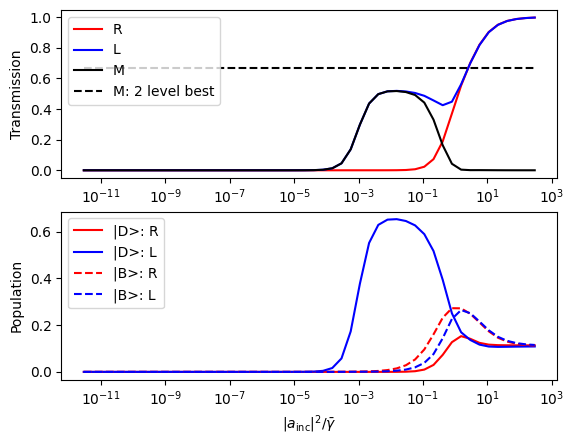

In [39]:
fig_1, ax = plt.subplots(2, 1)

p_for_plot = cir_parameters(cirs, [L_j1_list, L_j2_list], a_inc)

ax[0].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), transmission_R, color='r', label='R')
ax[0].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), transmission_L, color='b', label='L')
ax[0].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), efficiency, color='black', label='M')
ax[0].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), [0.67 for j in a_inc_list], '--',color='black', label='M: 2 level best')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$|a_\mathrm{inc}|^2 / \bar{\gamma}$')
ax[0].set_ylabel('Transmission')
#ax[0].set_ylim(0,1)
ax[0].legend()

ax[1].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), pop_D_R, color='r', label='|D>: R')
ax[1].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), pop_D_L, color='b', label='|D>: L')
ax[1].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), pop_B_R, '--', color='r', label='|B>: R')
ax[1].plot(a_inc_list**2 / np.mean(p_for_plot["gammas"]), pop_B_L, '--', color='b', label='|B>: L')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$|a_\mathrm{inc}|^2 / \bar{\gamma}$')
ax[1].set_ylabel('Population')
#ax[1].set_ylim(0,1)
ax[1].legend()

In [45]:
np.max(efficiency)

0.5251410183815365

In [161]:
sc.linalg.eigvals(p['Gamma'])

array([5.52130550e+04+0.j, 1.02390627e+09+0.j])

In [84]:
test_dict = {}
for i in range(10):
    test_dict.update({str(i): i})

### Write power dependence to file

In [162]:
dict_power = {'a_inc_list': a_inc_list, 'L_js': [L_j1_list, L_j2_list], 'gammas': p_for_plot["gammas"], 'delta': p_for_plot["delta"], 
             'transmission_R': transmission_R, 'transmission_L': transmission_L, 'efficiency': efficiency,
             'population_B_L': pop_B_L, 'population_D_L': pop_D_L, 'population_B_R': pop_B_R, 'population_D_R': pop_D_R}

In [163]:
write_h5(PATH_DATA+"power_dependence_Nexc"+ str(N_excitations) +"_delta_" + 
         str(np.round(p_for_plot['delta'], decimals=4)) + ".h5", dict_power)

a_inc_list [3.87298335e-02 4.00012613e-02 4.13144278e-02 4.26707030e-02
 4.40715022e-02 4.55182870e-02 4.70125671e-02 4.85559016e-02
 5.01499008e-02 5.17962281e-02 5.34966012e-02 5.52527943e-02
 5.70666400e-02 5.89400309e-02 6.08749216e-02 6.28733312e-02
 6.49373449e-02 6.70691162e-02 6.92708696e-02 7.15449024e-02
 7.38935875e-02 7.63193755e-02 7.88247975e-02 8.14124679e-02
 8.40850867e-02 8.68454425e-02 8.96964156e-02 9.26409808e-02
 9.56822106e-02 9.88232783e-02 1.02067461e-01 1.05418145e-01
 1.08878825e-01 1.12453113e-01 1.16144738e-01 1.19957552e-01
 1.23895533e-01 1.27962792e-01 1.32163570e-01 1.36502252e-01
 1.40983366e-01 1.45611585e-01 1.50391741e-01 1.55328820e-01
 1.60427974e-01 1.65694524e-01 1.71133964e-01 1.76751972e-01
 1.82554408e-01 1.88547327e-01 1.94736982e-01 2.01129832e-01
 2.07732548e-01 2.14552018e-01 2.21595359e-01 2.28869919e-01
 2.36383289e-01 2.44143310e-01 2.52158077e-01 2.60435954e-01
 2.68985579e-01 2.77815871e-01 2.86936045e-01 2.96355618e-01
 3.06084418e-

'File .h5 wrote successfully'

In [499]:
L_j_list = np.linspace(3.15e-9, 3.45e-9, 2*NMAX)
L_j_list = np.insert(L_j_list, NMAX, L_js[1])

In [225]:
# Efficiency study (far from the resonance)
from IPython.display import clear_output

L_j_list = np.linspace(3.15e-9, 3.45e-9, 2*NMAX)
eff = np.zeros((len(L_j_list), NMAX))
trans_R = np.zeros((len(L_j_list), NMAX))
trans_L = np.zeros((len(L_j_list), NMAX))
for j in range(len(L_j_list)):
    tr_R = np.array(qt.parallel_map(transmission_power_dependence, 
                                              a_inc_list, task_args=(L_j_list[j], L_j2_list, ),
                                              task_kwargs=dict(direction='R')))[:, 0]
    tr_L = np.array(qt.parallel_map(transmission_power_dependence, 
                                              a_inc_list, task_args=(L_j_list[j], L_j2_list, ),  
                                              task_kwargs=dict(direction='L')))[:, 0]
    eff[j] = (np.maximum(tr_L, tr_R)*np.abs((tr_L - tr_R) /
                          (tr_L + tr_R)))
    trans_R[j] = tr_R
    trans_L[j] = tr_L
    clear_output(wait=True)  # Clear the output of the current cell
    print(j, ' out of ', len(L_j_list), "\n")

99  out of  100 



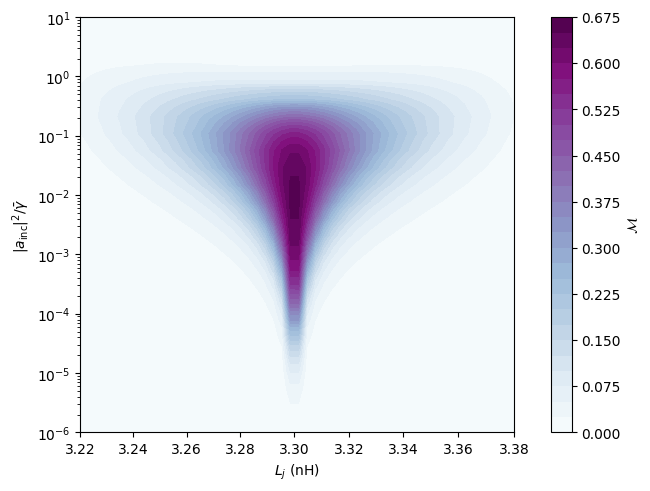

In [226]:
from matplotlib.ticker import NullFormatter, FixedLocator

X = L_j_list / 1e-9
Y = a_inc_list**2 / np.mean(p_for_plot["gammas"])
fig_eff, ax = plt.subplots(1,1, constrained_layout = True)
cm0 = ax.contourf(X, Y, eff.T, cmap="BuPu", levels=30)
ax.set_xscale('function', functions=(lambda x: (x)**2, lambda x: (x)**(1/2)))
ax.set_yscale('log')
#ax.grid(True)
ax.set_xlabel(r"$L_j$ (nH)")
ax.set_ylabel(r'$|a_\mathrm{inc}|^2 / \bar{\gamma}$')
ax.set_xlim(3.22, 3.38)
ax.set_ylim(1e-6, 1e1)
fig_eff.colorbar(cm0, ax=ax, label=r"$\mathcal{M}$")
plt.show()


### Write power and $L_j$ dependence to file

In [227]:
dict_power_Lj = {'a_inc_list': a_inc_list, 'L_j_list': L_j_list, 
             'transmission_R': trans_R, 'transmission_L': trans_L, 'efficiency': eff}

write_h5(PATH_DATA+"power_Lj_dependence_Nexc"+ str(N_excitations) + ".h5", dict_power_Lj)

a_inc_list [3.87298335e-02 5.38149291e-02 7.47756015e-02 1.03900361e-01
 1.44369084e-01 2.00600192e-01 2.78733063e-01 3.87298335e-01
 5.38149291e-01 7.47756015e-01 1.03900361e+00 1.44369084e+00
 2.00600192e+00 2.78733063e+00 3.87298335e+00 5.38149291e+00
 7.47756015e+00 1.03900361e+01 1.44369084e+01 2.00600192e+01
 2.78733063e+01 3.87298335e+01 5.38149291e+01 7.47756015e+01
 1.03900361e+02 1.44369084e+02 2.00600192e+02 2.78733063e+02
 3.87298335e+02 5.38149291e+02 7.47756015e+02 1.03900361e+03
 1.44369084e+03 2.00600192e+03 2.78733063e+03 3.87298335e+03
 5.38149291e+03 7.47756015e+03 1.03900361e+04 1.44369084e+04
 2.00600192e+04 2.78733063e+04 3.87298335e+04 5.38149291e+04
 7.47756015e+04 1.03900361e+05 1.44369084e+05 2.00600192e+05
 2.78733063e+05 3.87298335e+05]
L_j_list [3.15000000e-09 3.15303030e-09 3.15606061e-09 3.15909091e-09
 3.16212121e-09 3.16515152e-09 3.16818182e-09 3.17121212e-09
 3.17424242e-09 3.17727273e-09 3.18030303e-09 3.18333333e-09
 3.18636364e-09 3.18939394e-09 3.

'File .h5 wrote successfully'